## Goal

The goal of this notebook is to aquiring, cleaning, and analysing asthma data for the Philedelphia area. As primary effects, younger kids and older adults. To look into this trend, I will be using datasets One containing the hospitalization, data of kids under 18 years age and other containing death data, which is retrieved from the CDC wonder dataset.


The data will subsequently be used to create a model that can predict the number of asthma related emergency room visits and deaths in the Philedelphia area. 

# License

The code in the notebook is licensed under the standard [MIT license](LICENSE).



First, we import essential libraries - pandas for data manipulation and numpy for numerical computations, matplotlib for visualising the acquired data.


- `pandas`: A powerful data manipulation and analysis library for Python.
- `numpy`: A fundamental package for scientific computing with Python, providing support for arrays and matrices.
- `polars`: A fast DataFrame library for Rust and Python, designed for performance and ease of use.
- `matplotlib.pyplot`: A plotting library for creating static, animated, and interactive visualizations in Python.
- `seaborn`: A statistical data visualization library based on matplotlib, providing a high-level interface for drawing attractive and informative statistical graphics.
- `statsmodels.tools.eval_measures.rmse`: A function to calculate the root mean square error, a measure of the differences between predicted and observed values.
- `warnings`: A built-in Python module for issuing warning messages.
- `sklearn.preprocessing.StandardScaler`: A module for standardizing features by removing the mean and scaling to unit variance.
- `scipy.stats.pearsonr`: A function to calculate the Pearson correlation coefficient and p-value for testing non-correlation.
- `scipy.stats.kendalltau`: A function to calculate Kendall's tau, a measure of correlation between two variables.
- `scipy.stats`: A module that contains a large number of probability distributions as well as a growing library of statistical functions.


In [2]:
import pandas as pd
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import scipy.stats
from statsmodels.tsa.statespace.sarimax import SARIMAX



## All Deaths due respiratory dieseases in Philedelphia county

First, we load the data from the CDC wonder dataset. The data contains the number of deaths due to respiratory diseases in Philedelphia county. The data is loaded into a pandas dataframe and displayed. then, it is converted to a polars dataframe for further processing.

In [3]:
#read csv file
all_resp_deaths = pd.read_csv('initial data files/all disease deaths 1999-2020.txt', sep='\t')
#convert to polars
all_resp_deaths = pl.DataFrame(all_resp_deaths)
all_resp_deaths

Notes,Year,Year Code,Deaths,Population,Crude Rate
f64,i64,i64,i64,i64,f64
null,1999,1999,3699,1520064,243.3
null,2000,2000,3670,1517550,241.8
null,2001,2001,3448,1505455,229.0
null,2002,2002,3415,1498493,227.9
null,2003,2003,3255,1493802,217.9
…,…,…,…,…,…
null,2016,2016,2567,1567872,163.7
null,2017,2017,2303,1580863,145.7
null,2018,2018,2277,1584138,143.7


Below, we get the deaths for all respiratory diseases in Philedelphia county per 100000 people.

In [4]:
#get deaths per 100000 people
all_resp_deaths_per_100000 = (
    all_resp_deaths
    .with_columns(
        (
            pl.col('Deaths') / pl.col('Population') * 100000).alias('Deaths per 100000')
    )
    .select(
        'Year', 'Deaths','Population','Deaths per 100000'
    )
)
all_resp_deaths_per_100000

Year,Deaths,Population,Deaths per 100000
i64,i64,i64,f64
1999,3699,1520064,243.345017
2000,3670,1517550,241.837172
2001,3448,1505455,229.033747
2002,3415,1498493,227.895626
2003,3255,1493802,217.900364
…,…,…,…
2016,2567,1567872,163.7251
2017,2303,1580863,145.679923
2018,2277,1584138,143.737477


## Kids data for asthma discharges in Philadelphia county

Here, we load the data from the PHC4 dataset. The data contains the number of asthma discharges in Philadelphia county for kids under 18 years of age. The data is loaded into a pandas dataframe and displayed. then, it is converted to a polars dataframe for further processing.

In [5]:
#read csv file
asthma_kids_discharges = pd.read_csv('initial data files/hospitalization Discharges Asthma kids per 100,000.csv')
#convert to polars
asthma_kids_discharges = pl.DataFrame(asthma_kids_discharges)
asthma_kids_discharges

TRatePercent,Health_Events,Geography,Calendar_Year,Gender,Race_Ethnicity,Age,Count,Population,DT_RATE,DT_LB,DT_UB1,Significance,Geography_Code
str,str,str,i64,str,str,str,str,str,str,f64,str,str,i64
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2023,"""Total""","""All Races""","""All Children (Age 0-17)""","""1,251""","""330,745""","""378.2""",357.3,"""399.2""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2022,"""Total""","""All Races""","""All Children (Age 0-17)""","""1,019""","""338,710""","""300.8""",282.4,"""319.3""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2021,"""Total""","""All Races""","""All Children (Age 0-17)""","""734""","""343,517""","""213.7""",198.2,"""229.1""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2020,"""Total""","""All Races""","""All Children (Age 0-17)""","""1200""","""347,602""","""175.8""",161.8,"""189.7""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2019,"""Total""","""All Races""","""All Children (Age 0-17)""","""2042""","""341,496""","""422.3""",400.5,"""444.1""","""+""",101
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2004,"""Total""","""All Races""","""All Children (Age 0-17)""","""3,186""","""372,065""","""856.3""",826.6,"""886.0""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2003,"""Total""","""All Races""","""All Children (Age 0-17)""","""3,723""","""377,212""","""987.0""",955.3,"""1,018.7""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2002,"""Total""","""All Races""","""All Children (Age 0-17)""","""3,071""","""381,802""","""804.3""",775.9,"""832.8""","""+""",101


Below, we convert the Year column to a datetime object and count and populations to int types

In [6]:
asthma_kids_discharges = (
    asthma_kids_discharges
    .rename(
        {"Calendar_Year": "Year"}
        )
    .with_columns(
        pl.col('Count').str.replace(',', '').cast(pl.Int32).alias('Count'),
        pl.col('Population').str.replace(',', '').cast(pl.Int32).alias('Population')
    )
)
asthma_kids_discharges

TRatePercent,Health_Events,Geography,Year,Gender,Race_Ethnicity,Age,Count,Population,DT_RATE,DT_LB,DT_UB1,Significance,Geography_Code
str,str,str,i64,str,str,str,i32,i32,str,f64,str,str,i64
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2023,"""Total""","""All Races""","""All Children (Age 0-17)""",1251,330745,"""378.2""",357.3,"""399.2""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2022,"""Total""","""All Races""","""All Children (Age 0-17)""",1019,338710,"""300.8""",282.4,"""319.3""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2021,"""Total""","""All Races""","""All Children (Age 0-17)""",734,343517,"""213.7""",198.2,"""229.1""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2020,"""Total""","""All Races""","""All Children (Age 0-17)""",1200,347602,"""175.8""",161.8,"""189.7""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2019,"""Total""","""All Races""","""All Children (Age 0-17)""",2042,341496,"""422.3""",400.5,"""444.1""","""+""",101
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2004,"""Total""","""All Races""","""All Children (Age 0-17)""",3186,372065,"""856.3""",826.6,"""886.0""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2003,"""Total""","""All Races""","""All Children (Age 0-17)""",3723,377212,"""987.0""",955.3,"""1,018.7""","""+""",101
"""Crude/Age-Specific Rate""","""Asthma""","""Philadelphia""",2002,"""Total""","""All Races""","""All Children (Age 0-17)""",3071,381802,"""804.3""",775.9,"""832.8""","""+""",101


Here, we get the number of asthma discharges for kids under 18 years of age in Philedelphia county per 100000 people.

In [7]:
#get deaths per 100000 people
asthma_kids_discharges_100000 = (
    asthma_kids_discharges
    .with_columns(
        (   pl.col("Count").cast(pl.Int64) / pl.col('Population').cast(pl.Int64) * 100000).alias('discharges per 100000')
    )
    .select(
        'Year', 'Count','Population','discharges per 100000'
    )
)
asthma_kids_discharges_100000

Year,Count,Population,discharges per 100000
i64,i32,i32,f64
2023,1251,330745,378.23701
2022,1019,338710,300.847333
2021,734,343517,213.672104
2020,1200,347602,345.22241
2019,2042,341496,597.957224
…,…,…,…
2004,3186,372065,856.30199
2003,3723,377212,986.978145
2002,3071,381802,804.343613


## Asthma related deaths in Philadelphia county all ages

Here, we load the data from the CDC wonder dataset. The data contains the number of deaths due to asthma in Philadelphia county. The data is loaded into a pandas dataframe and displayed. then, it is converted to a polars dataframe for further processing.

[]

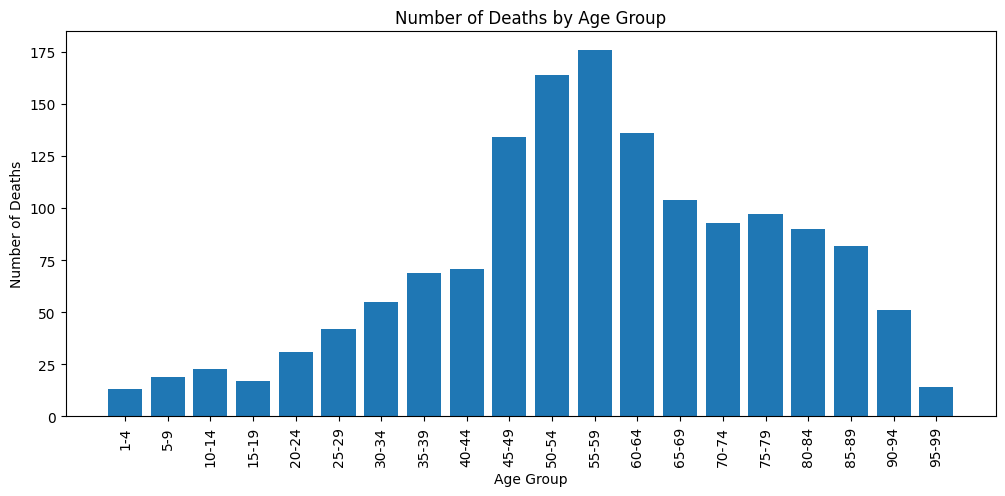

In [15]:
death_by_age = pd.read_csv("initial data files/death asthma by. age.txt", sep="\t")
death_by_age

plt.figure(figsize=(12, 5))
plt.bar(death_by_age["Five-Year Age Groups Code"], death_by_age["Deaths"])
plt.xlabel("Age Group")
plt.ylabel("Number of Deaths")
plt.title("Number of Deaths by Age Group")
plt.xticks(rotation=90)

plt.plot()

Here we see that the 

In [16]:
death_file = pd.read_csv("initial data files/Asthma_deaths_cdc.txt", sep="\t", index_col="Year")

In [17]:
death_file

,Notes,Year Code,Multiple Cause of death,Multiple Cause of death Code,Deaths,Population,Crude Rate
Year,,,,,,,
1999,NaN,1999,"Asthma, unspecified",J45.9,61,1520064,4.0
2000,NaN,2000,"Asthma, unspecified",J45.9,73,1517550,4.8
2001,NaN,2001,"Asthma, unspecified",J45.9,69,1505455,4.6
2002,NaN,2002,"Asthma, unspecified",J45.9,76,1498493,5.1
2003,NaN,2003,"Asthma, unspecified",J45.9,87,1493802,5.8
2004,NaN,2004,"Asthma, unspecified",J45.9,55,1492882,3.7
2005,NaN,2005,"Asthma, unspecified",J45.9,55,1490861,3.7
2006,NaN,2006,"Asthma, unspecified",J45.9,62,1488710,4.2
2007,NaN,2007,"Asthma, unspecified",J45.9,58,1493309,3.9


Plotting deaths per yeear

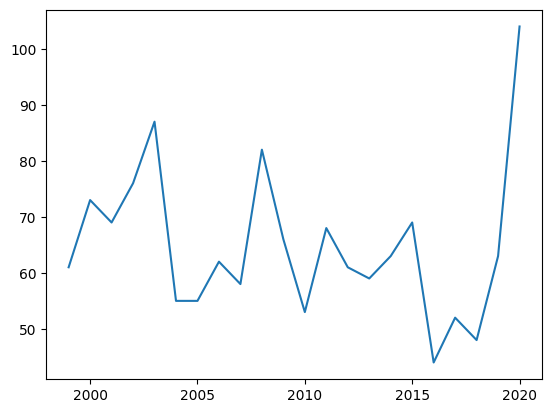

In [18]:
plt.plot(death_file["Deaths"])

## Smoke impact (past + predicted) calculated in part 1

Here, we take the data from the previous notebook and merge the past and forecasts to create one dataset

In [19]:
smoke_metric = pd.read_csv("intermediate data files/smoke_metric_historical.csv")
smoke_metric.head()

,Fire_Year,smoke_metric
0,1962,34.081084
1,1963,13.071290
2,1964,0.695634
3,1965,0.538599
4,1966,0.276700


In [20]:
smoke_pl = pl.DataFrame(smoke_metric)
smoke_pl_filtered = smoke_pl.filter(pl.col("Fire_Year") > 1998)

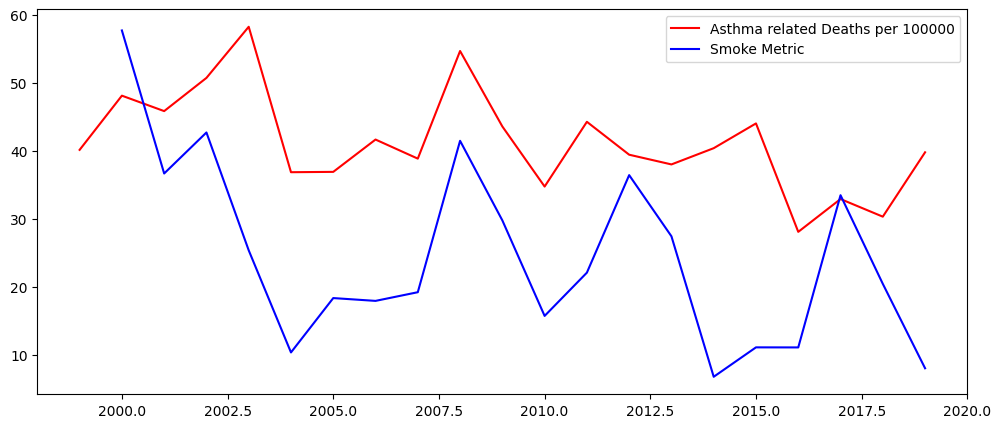

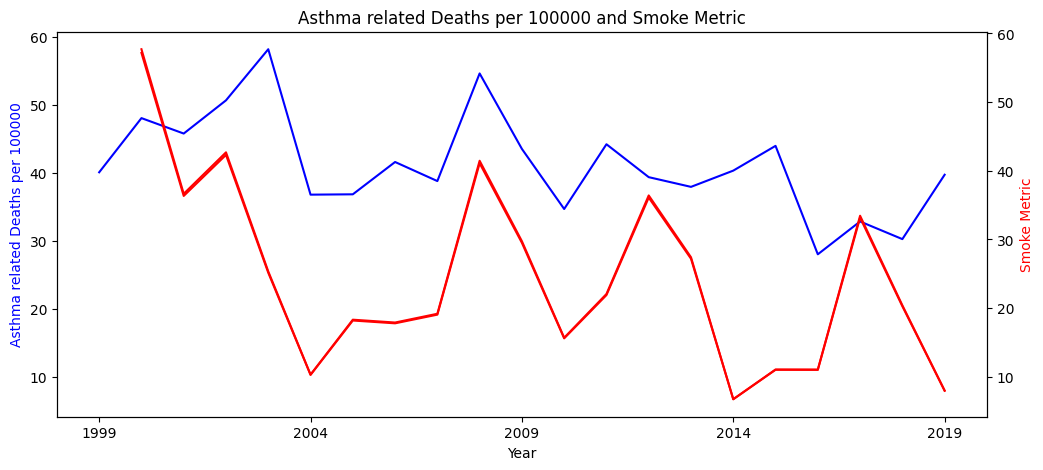

In [21]:
#plot size
plt.figure(figsize=(12, 5))

plt.plot(death_file["Deaths"][:-1]*1000000/death_file["Population"][:-1], color="red", label="Asthma related Deaths per 100000")
plt.plot(smoke_pl_filtered["Fire_Year"][1:-1], smoke_pl_filtered["smoke_metric"][:-2], color="blue", label="Smoke Metric")
plt.legend()

#plot size

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(death_file["Deaths"][:-1]*1000000/death_file["Population"][:-1], color="blue")
ax1.set_ylabel('Asthma related Deaths per 100000', color='blue')
ax1.set_xlabel('Year')
ax1.set_title('Asthma related Deaths per 100000 and Smoke Metric')
#year values on x-axis only every 5 years
plt.xticks(np.arange(1999, 2021, 5))

# Create second y-axis
ax2 = ax1.twinx()

# Plot the second dataset on the right y-axis
ax2.plot(smoke_pl_filtered["Fire_Year"][1:-1], smoke_pl_filtered["smoke_metric"][:-2], color="red")
ax1.plot(smoke_pl_filtered["Fire_Year"][1:-1], smoke_pl_filtered["smoke_metric"][:-2], color="red")

ax2.set_ylabel('Smoke Metric', color='red')

# Show the plot

plt.xlabel("Year")

plt.show()

Plotting asthma death in the smoke metric we see that there is a good visual correlation between both of them. Dismiss the good trains and forecasting asthma in the future, using smoke metric would be a good idea.

In [22]:
smoke_indexed = smoke_pl_filtered.to_pandas().set_index('Fire_Year')

There seem to be some Correlation between the lagged Smoke me the number of Asthma deaths. Hence, we shift the smoke by one year.

In [23]:
#correlation in python
import scipy.stats
correlation_coefficient, p_value = scipy.stats.pearsonr(death_file["Deaths"][1:-1]*1000000/death_file["Population"][1:-1], smoke_pl_filtered["smoke_metric"][:-2])


In [24]:
correlation_coefficient

np.float64(0.4956437698771349)

In [25]:
p_value

np.float64(0.02625970326414106)

A correlation of around the .5 is observed between the two datasets. Value of 0.026 shows that this is indeed Statistically significant value

My p-value cut off is: p-value is less than 0.05 -> significant result

In [26]:
death_file["death_per_million"] = death_file["Deaths"]*1000000/death_file["Population"]
death_file.reset_index(inplace=True)
death_fin_pd = death_file[['Year', 'Deaths']]

In [27]:
smoke_indexed = smoke_pl_filtered.to_pandas().set_index('Fire_Year', inplace=True)

In [28]:
forcasted_smoke = pl.read_csv("intermediate data files/forecasted_smoke_impact.csv")

## Dividing smoke data into training and testing data

In [29]:
#smoke data from 1999-2020
previous_smoke = smoke_pl_filtered.rename({"Fire_Year": "Year"})
previous_smoke

Year,smoke_metric
i64,f64
1999,57.700703
2000,36.653385
2001,42.687382
2002,25.347045
2003,10.322857
…,…
2016,33.456501
2017,20.416088
2018,7.992868


In [30]:
#smoke data from 2020-2050
forcasted_smoke = forcasted_smoke.rename({"predicted_mean": "smoke_metric"})
forcasted_smoke = forcasted_smoke.select("Year", "smoke_metric")
forcasted_smoke

Year,smoke_metric
i64,f64
2021,27.04783
2022,27.076214
2023,28.16652
2024,29.512774
2025,30.920717
…,…
2046,60.892689
2047,62.320222
2048,63.747755


In [31]:
overall_smoke_predicted = previous_smoke.vstack(forcasted_smoke)
overall_smoke_predicted

Year,smoke_metric
i64,f64
1999,57.700703
2000,36.653385
2001,42.687382
2002,25.347045
2003,10.322857
…,…
2046,60.892689
2047,62.320222
2048,63.747755


## Asthma Deathsm data analysis

In [60]:
#load death data file
death_file = pd.read_csv("initial data files/Asthma_deaths_cdc.txt", sep="\t", index_col="Year")

In [62]:
# Convert death_file DataFrame from pandas to polars
death_data = pl.from_pandas(death_file)

# Select relevant columns and rename them
historical_deaths = death_data.select("Year Code", "Deaths", "Population")
historical_deaths = historical_deaths.rename({"Year Code": "Year"})

In [64]:
#below code is to calculate deaths per million
historical_deaths_dpm = historical_deaths.with_columns(
    
        ((pl.col("Deaths") * 1000000) / pl.col("Population")).alias("Deaths per million")
    
)

In [66]:
#we will use only these 2 columns
hist_deaths_dpm = historical_deaths_dpm.select("Year", "Deaths per million")

In [67]:
hist_deaths_dpm

Year,Deaths per million
i64,f64
1999,40.129889
2000,48.103852
2001,45.833319
2002,50.717621
2003,58.24065
…,…
2016,28.063515
2017,32.893426
2018,30.30039


Now we have both the asthma data and the total smoke data ready. We can use this to fit a model to predict asthma deaths.

In [69]:
#divide into training and future data
training_smoke_data = overall_smoke_predicted.filter(pl.col("Year") <= 2020)
future_smoke_data = overall_smoke_predicted.filter(pl.col("Year") >= 2021)

## Merging Deaths and Smoke Data

Below, we merge the deaths and smoke data to create a single dataset that can be used to train a model to predict asthma deaths.

In [42]:
training_data = training_smoke_data.join(hist_deaths_dpm, on="Year")

In [43]:
shifted_training_data = training_data.with_columns(
        
        pl.col("smoke_metric").shift(1).alias("smoke_metric_lag1")
)
shifted_training_data = shifted_training_data.filter(pl.col("Year").is_between(2000, 2019))

In [44]:
training_data_pd = training_data.to_pandas()

In [45]:
shifted_training_data_pd = shifted_training_data.to_pandas()
shifted_training_data_pd

,Year,smoke_metric,Deaths per million,smoke_metric_lag1
0,2000,36.653385,48.103852,57.700703
1,2001,42.687382,45.833319,36.653385
2,2002,25.347045,50.717621,42.687382
3,2003,10.322857,58.240650,25.347045
4,2004,18.321140,36.841492,10.322857
5,2005,17.907898,36.891434,18.321140
6,2006,19.184243,41.646795,17.907898
7,2007,41.461169,38.839919,19.184243
8,2008,29.751388,54.676472,41.461169
9,2009,15.696519,43.573157,29.751388


In [46]:
shifted_training_data_pd

,Year,smoke_metric,Deaths per million,smoke_metric_lag1
0,2000,36.653385,48.103852,57.700703
1,2001,42.687382,45.833319,36.653385
2,2002,25.347045,50.717621,42.687382
3,2003,10.322857,58.240650,25.347045
4,2004,18.321140,36.841492,10.322857
5,2005,17.907898,36.891434,18.321140
6,2006,19.184243,41.646795,17.907898
7,2007,41.461169,38.839919,19.184243
8,2008,29.751388,54.676472,41.461169
9,2009,15.696519,43.573157,29.751388


In [70]:
#divide into training and test data. Data hyas been shifted by 1 year
training_data_model = shifted_training_data.filter(pl.col("Year").is_between(2000, 2015))
test_data_model = shifted_training_data.filter(pl.col("Year").is_between(2016, 2019))
training_data_model = training_data_model.to_pandas()
test_data_model = test_data_model.to_pandas()

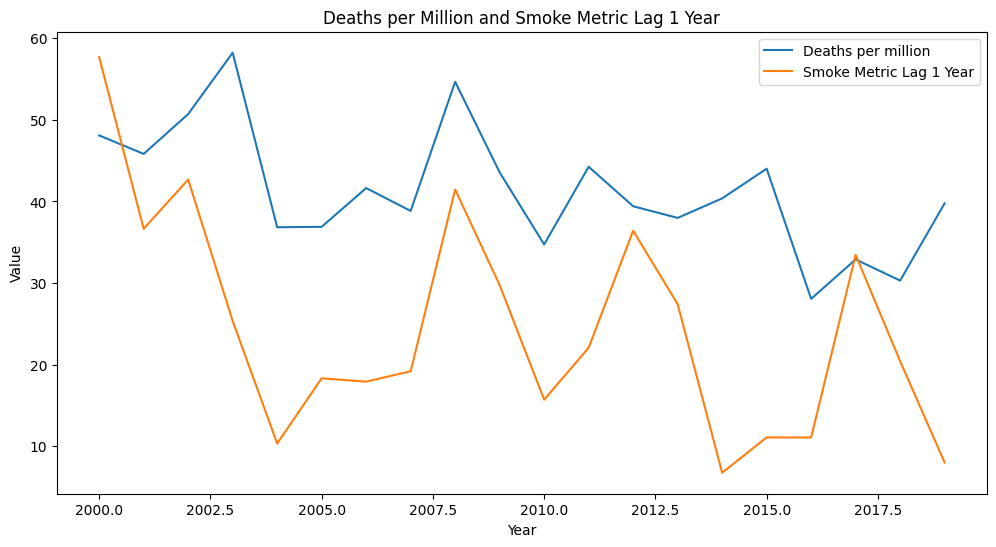

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["Deaths per million"], label="Deaths per million")
plt.plot(shifted_training_data_pd["Year"], shifted_training_data_pd["smoke_metric_lag1"], label="Smoke Metric Lag 1 Year")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Deaths per Million and Smoke Metric Lag 1 Year")
plt.legend()
plt.show()

Above chart shows good correlation between the two datasets. This means that the smoke data can be used to predict the number of asthma deaths.

In [49]:
print(correlation_coefficient, p_value)

0.4956437698771349 0.02625970326414106


We are done with the cleaning, exploration, and analysis of the data. We can now move on to the next step, which is to build a model to predict the number of asthma deaths in Philadelphia county.

Below, we take all the intermediate tables and save them as csv files for further processing in the next notebook.

In [58]:
training_data_model.to_csv("intermediate data files/training_data_model.csv")
test_data_model.to_csv("intermediate data files/test_data_model.csv")
shifted_training_data_pd.to_csv("intermediate data files/shifted_training_data.csv")
future_smoke_data.to_pandas().to_csv("intermediate data files/future_smoke_data.csv")
asthma_kids_discharges_100000.to_pandas().to_csv("intermediate data files/asthma_kids_discharges_100000.csv")
shifted_training_data.to_pandas().to_csv("intermediate data files/shifted_training_data.csv")